In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import sys
import time

from util import *

## Load the COMPAS dataset

In [2]:
# Load COMPAS data
X,y,sensitive_features = load_compas_X_y_s(datasets)

# Split dataset into 4 sub-groups and retrieve the indices
subgroups_indices = get_lable_group_index(X, y, sensitive_features)

## Define the beginning points and the transition probabilities

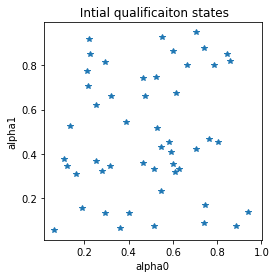

In [5]:
# Define the start point of qualification rates
np.random.seed(777)

NUM_SAMPLES = 50
P0 = 0.8
alpha0List = np.random.uniform(0.05,0.95,NUM_SAMPLES)
alpha1List = np.random.uniform(0.05,0.95,NUM_SAMPLES)


plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot(alpha0List,alpha1List,'*',label='Initial points')

plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.axis('square')
plt.title(" Intial qualificaiton states")
plt.show()

In [6]:
# Define the transition matrix 
# The order of index in T: 
# ["qualification state", "decision", "group"]
T = np.zeros((2, 2, 2))
T[0,0,0] = 0.7
T[0,1,0] = 0.5
T[1,0,0] = 0.5
T[1,1,0] = 0.1

T[0,0,1] = 0.9 # "Caucasian"
T[0,1,1] = 0.5
T[1,0,1] = 0.5
T[1,1,1] = 0.3

## The evolution trajectory of qualification states   
- UN: uncontrained  
- DP: disparate parity  
- EqOpt: equal of opportunity  

### The UN case
- The study of the evolution behavior: the equilibirum jump between two points  
- The study of equilibirum states

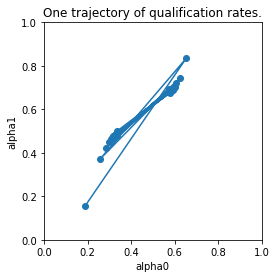

In [20]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50

k=0

alpha0, alpha1 =  alpha0List[k],alpha1List[k]
alpha0_un_evolution=[alpha0]
alpha1_un_evolution=[alpha1]
t = 0
while t < MAX_ITERATION_EQUILIBRIUM:
    t+=1
    # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    # sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

    # train (fair) classifiers
    pr_un,acc_un,tpr_un,fpr_un = eva_classifier(X_train,y_train,sensitive_features_train)

    # transitions
    alpha0_un_evolution.append(transition(alpha0,
                                          tpr_un["African-American"],
                                          fpr_un["African-American"],
                                          T, group = 0))

    alpha1_un_evolution.append(transition(alpha1,
                                          tpr_un["Caucasian"],fpr_un["Caucasian"],
                                          T, group = 1))

    alpha0 = alpha0_un_evolution[-1]
    alpha1 = alpha1_un_evolution[-1]

plt.figure()
plt.axis('square')
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.plot(alpha0_un_evolution,alpha1_un_evolution,'o-')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("One trajectory of qualification rates.")
plt.show()


49

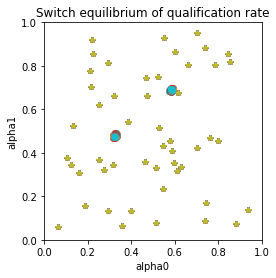

In [21]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50

plt.figure()

for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_un_evolution=[alpha0]
    alpha1_un_evolution=[alpha1]
    t = 0
    while t < MAX_ITERATION_EQUILIBRIUM:
        t+=1
        # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
        ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  
        
        # sample individuals from 4 sub-groups
        X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)
        
        # train (fair) classifiers
        pr_un,acc_un,tpr_un,fpr_un = eva_classifier(X_train,y_train,sensitive_features_train)
        
        # transitions
        alpha0_un_evolution.append(transition(alpha0,
                                              tpr_un["African-American"],
                                              fpr_un["African-American"],
                                              T, group = 0))
        
        alpha1_un_evolution.append(transition(alpha1,
                                              tpr_un["Caucasian"],fpr_un["Caucasian"],
                                              T, group = 1))

        alpha0 = alpha0_un_evolution[-1]
        alpha1 = alpha1_un_evolution[-1]
    plt.axis('square')
    plt.plot(alpha0List,alpha1List,'*')
    plt.xlabel('alpha0')
    plt.ylabel('alpha1')
    plt.plot(alpha0_un_evolution[-5:],alpha1_un_evolution[-5:],'o',label='No.'+str(k))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.title("Switch equilibrium of qualification rate")
plt.show()


### The DP case
- The study of the evolution behavior: the equilibirum jump between two points  
- The study of equilibirum states

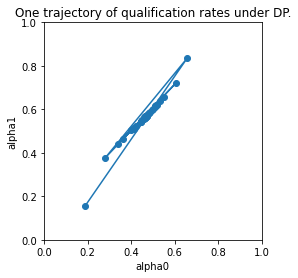

In [17]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50

k=0

alpha0, alpha1 =  alpha0List[k],alpha1List[k]
alpha0_dp_evolution=[alpha0]
alpha1_dp_evolution=[alpha1]
t = 0
while t < MAX_ITERATION_EQUILIBRIUM:
    t+=1
    # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    # sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

    # train (fair) classifiers
    pr,acc,tpr,fpr = eva_classifier_dp(X_train,y_train,sensitive_features_train)

    # transitions
    alpha0_dp_evolution.append(transition(alpha0,
                                          tpr["African-American"],
                                          fpr["African-American"],
                                          T, group = 0))

    alpha1_dp_evolution.append(transition(alpha1,
                                          tpr["Caucasian"],fpr["Caucasian"],
                                          T, group = 1))

    alpha0 = alpha0_dp_evolution[-1]
    alpha1 = alpha1_dp_evolution[-1]

plt.figure()
plt.axis('square')
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.plot(alpha0_dp_evolution,alpha1_dp_evolution,'o-')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("One trajectory of qualification rates under DP.")
plt.show()


49

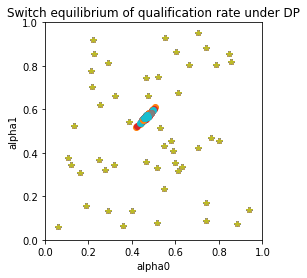

In [18]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50

plt.figure()

for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_dp_evolution=[alpha0]
    alpha1_dp_evolution=[alpha1]
    t = 0
    while t < MAX_ITERATION_EQUILIBRIUM:
        t+=1
        # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
        ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  
        
        # sample individuals from 4 sub-groups
        X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)
        
        # train (fair) classifiers
        pr,acc,tpr,fpr = eva_classifier_dp(X_train,y_train,sensitive_features_train)
        
        # transitions
        alpha0_dp_evolution.append(transition(alpha0,
                                              tpr["African-American"],
                                              fpr["African-American"],
                                              T, group = 0))
        
        alpha1_dp_evolution.append(transition(alpha1,
                                              tpr["Caucasian"],fpr["Caucasian"],
                                              T, group = 1))

        alpha0 = alpha0_dp_evolution[-1]
        alpha1 = alpha1_dp_evolution[-1]
    plt.axis('square')
    plt.plot(alpha0List,alpha1List,'*')
    plt.xlabel('alpha0')
    plt.ylabel('alpha1')
    plt.plot(alpha0_dp_evolution[-5:],alpha1_dp_evolution[-5:],'o',label='No.'+str(k))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.title("Switch equilibrium of qualification rate under DP")
plt.show()


### The EqOpt case
- The study of the evolution behavior: the equilibirum jump between two points  
- The study of equilibirum states

In [19]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50

k=0

alpha0, alpha1 =  alpha0List[k],alpha1List[k]
alpha0_eqopt_evolution=[alpha0]
alpha1_eqopt_evolution=[alpha1]
t = 0
while t < MAX_ITERATION_EQUILIBRIUM:
    t+=1
    # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    # sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

    # train (fair) classifiers
    pr,acc,tpr,fpr = eva_classifier_eqopt(X_train,y_train,sensitive_features_train)

    # transitions
    alpha0_eqopt_evolution.append(transition(alpha0,tpr["African-American"],
                                             fpr["African-American"],
                                             T, group = 0))

    alpha1_eqopt_evolution.append(transition(alpha1,tpr["Caucasian"],
                                             fpr["Caucasian"],
                                             T, group = 1))

    alpha0 = alpha0_eqopt_evolution[-1]
    alpha1 = alpha1_eqopt_evolution[-1]

plt.figure()
plt.axis('square')
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.plot(alpha0_eqopt_evolution,alpha1_eqopt_evolution,'o-')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("One trajectory of qualification rates under EqOpt.")
plt.show()


NameError: name 'eva_classifier_eqopt' is not defined

In [ ]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50

plt.figure()

for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_eqopt_evolution=[alpha0]
    alpha1_eqopt_evolution=[alpha1]
    t = 0
    while t < MAX_ITERATION_EQUILIBRIUM:
        t+=1
        # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
        ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

        # sample individuals from 4 sub-groups
        X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

        # train (fair) classifiers
        pr,acc,tpr,fpr = eva_classifier_eqopt(X_train,y_train,sensitive_features_train)

        # transitions
        alpha0_eqopt_evolution.append(transition(alpha0,tpr["African-American"],
                                                 fpr["African-American"],
                                                 T, group = 0))

        alpha1_eqopt_evolution.append(transition(alpha1,tpr["Caucasian"],
                                                 fpr["Caucasian"],
                                                 T, group = 1))

        alpha0 = alpha0_eqopt_evolution[-1]
        alpha1 = alpha1_eqopt_evolution[-1]
    plt.axis('square')
    plt.plot(alpha0List,alpha1List,'*')
    plt.xlabel('alpha0')
    plt.ylabel('alpha1')
    plt.plot(alpha0_eqopt_evolution[-5:],alpha1_eqopt_evolution[-5:],'o',label='No.'+str(k))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.title("Switch equilibrium of qualification rate under EqOpt")
plt.show()


8